In [123]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble
from pygam import LinearGAM
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [32]:
# read in imputed data
sensor_census_imp = pd.read_csv('../data/sensor_census_imputed_rf.csv')

In [33]:
np.random.seed(1)

# get sites for test data
test_sites = np.random.choice(np.unique(sensor_census_imp['site'].values), round(len(np.unique(sensor_census_imp['site'].values))/6), replace = False)

# train sites/rows and x/y split
sensor_census_imp_train = sensor_census_imp[~sensor_census_imp['site'].isin(test_sites)]
sensor_census_imp_train_x = sensor_census_imp_train.iloc[:, 2:]
sensor_census_imp_train_y = sensor_census_imp_train.iloc[:, 1]

# test sites/rows and x/y split
sensor_census_imp_test = sensor_census_imp[sensor_census_imp['site'].isin(test_sites)]
sensor_census_imp_test_x = sensor_census_imp_test.iloc[:, 2:]
sensor_census_imp_test_y = sensor_census_imp_test.iloc[:, 1]

# standardize train and test data
standardizer = sklearn.preprocessing.StandardScaler(with_mean = True, with_std = True)
sensor_census_imp_train_x_stand = standardizer.fit_transform(sensor_census_imp_train_x)
sensor_census_imp_test_x_stand = standardizer.transform(sensor_census_imp_test_x)

In [34]:
# ridge tuning
ridge = sklearn.linear_model.Ridge(random_state = 1)

parameter_grid_ridge = {'alpha' : [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}

grid_ridge = sklearn.model_selection.GridSearchCV(ridge, parameter_grid_ridge, cv = 10, refit = 'r2')
grid_ridge.fit(sensor_census_imp_train_x_stand, sensor_census_imp_train_y.values)
test_pred_ridge = grid_ridge.predict(sensor_census_imp_test_x_stand)
test_r2_ridge = sklearn.metrics.r2_score(sensor_census_imp_test_y.values, test_pred_ridge)
print(grid_ridge.best_params_)
test_r2_ridge

{'alpha': 10}


0.76663525561902179

In [35]:
# lasso tuning
lasso = sklearn.linear_model.Lasso(random_state = 1, tol = 1e-3, max_iter = 5000)

parameter_grid_lasso = {'alpha' : [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}

grid_lasso = sklearn.model_selection.GridSearchCV(lasso, parameter_grid_lasso, cv = 10, refit = 'r2')
grid_lasso.fit(sensor_census_imp_train_x_stand, sensor_census_imp_train_y.values)
test_pred_lasso = grid_lasso.predict(sensor_census_imp_test_x_stand)
test_r2_lasso = sklearn.metrics.r2_score(sensor_census_imp_test_y.values, test_pred_lasso)
print(grid_lasso.best_params_)
test_r2_lasso

{'alpha': 0.001}


0.76687017097542165

In [84]:
# rf tuning
rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 100, random_state = 1, n_jobs = 2, verbose = 1)

parameter_grid_rf = {'max_features' : [40, 50, 60, 70, 80]}

grid_rf = sklearn.model_selection.GridSearchCV(rf, parameter_grid_rf, cv = 4, refit = 'r2')
grid_rf.fit(sensor_census_imp_train_x_stand, sensor_census_imp_train_y.values)
test_pred_rf = grid_rf.predict(sensor_census_imp_test_x_stand)
test_r2_rf = sklearn.metrics.r2_score(sensor_census_imp_test_y.values, test_pred_rf)
print(grid_rf.best_params_)
test_r2_rf

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: 

{'max_features': 70}


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   36.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


0.77682075932760575

In [108]:
# tuning gam
fit_splines = [True for i in range(sensor_census_imp_train_x_stand.shape[1])]
fit_splines[118] = False

fit_linear = [False for i in range(sensor_census_imp_train_x_stand.shape[1])]
fit_linear[118] = True

gam = LinearGAM(max_iter = 1000, fit_splines = fit_splines)

parameter_grid_gam = {'lam': np.logspace(-3, 3, 11), 'n_splines' : [4, 7, 10, 13], 'fit_linear' : [True, fit_linear]}

grid_gam = sklearn.model_selection.GridSearchCV(gam, parameter_grid_gam, scoring = sklearn.metrics.make_scorer(sklearn.metrics.r2_score), 
                                                cv = 4, refit = 'r2')
grid_gam.fit(sensor_census_imp_train_x_stand, sensor_census_imp_train_y.values)
test_pred_gam = grid_gam.predict(sensor_census_imp_test_x_stand)
test_r2_gam = sklearn.metrics.r2_score(sensor_census_imp_test_y.values, test_pred_gam)
print(grid_gam.best_params_)
test_r2_gam

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-S

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\pygam.py:1187: UserWarning: detected catergorical data for feature 119
  self._validate_data_dep_params(X)
C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


{'fit_linear': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'lam': 251.18864315095772, 'n_splines': 13}


0.7724362288001575

In [129]:
# want to see how r2 varies with training data size
train_sizes = [2000*(i+1) for i in range(5)]
train_sizes.append(sensor_census_imp_train_x_stand.shape[0])

r2_scores = []
for size in train_sizes:
    
    # fitting with best hyperparams from cross-validation
    rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 500, random_state = 4, n_jobs = 2, max_features = 60, verbose = 1)
    rf.fit(sensor_census_imp_train_x_stand[:size, :], sensor_census_imp_train_y.values[:size])
    test_pred = rf.predict(sensor_census_imp_test_x_stand)
    test_r2 = sklearn.metrics.r2_score(sensor_census_imp_test_y.values, test_pred)
    r2_scores.append(test_r2)
    
r2_scores

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   16.9s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   19.5s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   18.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   37.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   42.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.

[0.76605145008442499,
 0.76329433416927406,
 0.77941797490622866,
 0.78480099541398307,
 0.7874713617852841,
 0.78198204545720329]

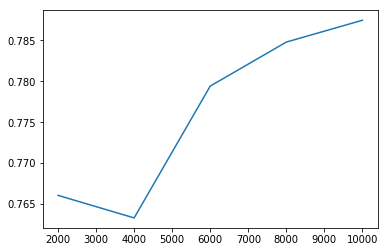

In [130]:
plt.plot(train_sizes[:-1], r2_scores[:-1])
plt.show()

In [136]:
# write true and predicted test vals to csv
test_true_pred_rfImp_best_rf = pd.DataFrame([sensor_census_imp_test_y.values, test_pred]).transpose()
test_true_pred_rfImp_best_rf.columns = ['true', 'pred']
test_true_pred_rfImp_best_rf.to_csv('../data/test_true_pred_rfImp_best_rf.csv', index = False)